In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import RMSprop
import tensorflow as tf
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Activation, Add, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
import requests
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [2]:
dos_dataset_path = "DoS_dataset.csv"
fuzzy_dataset_path = "Fuzzy_dataset.csv"
gear_dataset_path = "gear_dataset.csv"
rpm_dataset_path = "RPM_dataset.csv"
normal_dataset_path = "normal_run_data.7z"

def download_dataset(url, path):
    if not os.path.exists(path):
        print(f"Downloading {path}...")
        response = requests.get(url)
        with open(path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {path}.")

# Download datasets
download_dataset("https://www.dropbox.com/scl/fi/z8jsb04l83t1hb2ly7uuc/DoS_dataset.csv?rlkey=wuecz9xk1toujv9a32wffpt55&e=1&st=jwo5lyz3&dl=1", dos_dataset_path)
download_dataset("https://www.dropbox.com/scl/fi/cwiz1sfn6ke8b1qxbla1y/Fuzzy_dataset.csv?rlkey=qijei9ems39graxtxwwtabhps&e=1&st=tk40gj5h&dl=1", fuzzy_dataset_path)
download_dataset("https://www.dropbox.com/scl/fi/t98i9avxjdaihvrvadqew/gear_dataset.csv?rlkey=g3q9jchqv8umjzy20n4vnd3l4&e=1&st=p69qmjys&dl=1", gear_dataset_path)
download_dataset("https://www.dropbox.com/scl/fi/qwleo5jixvqm8upt7et6q/RPM_dataset.csv?rlkey=tn8hl2ykzz5h0wjjlhg99ufxu&e=1&st=8p3y5l34&dl=1", rpm_dataset_path)
download_dataset("https://www.dropbox.com/scl/fi/jjfq6pdlga5gj8i5lfm4a/normal_run_data.txt?rlkey=k97yczspwt2r3eq9hho9g07hj&e=1&st=svlrki8c&dl=1", normal_dataset_path)


Downloaded DoS_dataset.csv.
Downloaded Fuzzy_dataset.csv.
Downloaded gear_dataset.csv.
Downloaded RPM_dataset.csv.
Downloaded normal_run_data.7z.


In [3]:
!mv normal_run_data.7z normal_run_data.txt

In [2]:
# Define the file path
file_path = "normal_run_data.txt"

# Initialize an empty list to store the parsed rows
parsed_rows = []

# Open and parse the file
with open(file_path, "r") as file:
    for line in file:
        # Use a regular expression to extract data
        match = re.match(
            r"Timestamp:\s+(\S+)\s+ID:\s+(\S+)\s+(\S+)\s+DLC:\s+(\d+)\s+(.+)", line.strip()
        )
        if match:
            timestamp = match.group(1)
            can_id_part1 = match.group(2)
            can_id_part2 = match.group(3)
            dlc = int(match.group(4))
            data = match.group(5).split()  # Split the remaining data bytes
            # Ensure there are exactly 8 bytes
            data = data[:8] + [None] * (8 - len(data))  # Pad with None if fewer than 8 bytes
            # Append the row as a dictionary
            parsed_rows.append({
                'Timestamp': timestamp,
                'CAN ID': f"{can_id_part1} {can_id_part2}",
                'DLC': dlc,
                'DATA[0]': data[0],
                'DATA[1]': data[1],
                'DATA[2]': data[2],
                'DATA[3]': data[3],
                'DATA[4]': data[4],
                'DATA[5]': data[5],
                'DATA[6]': data[6],
                'DATA[7]': data[7],
                'Flag': "R"  # Set the default flag to "R"
            })

# Convert the list of dictionaries into a DataFrame
normal_run_data_df = pd.DataFrame(parsed_rows)
normal_run_data_df = normal_run_data_df[:739679]

# Display the DataFrame
normal_run_data_df


,Timestamp,CAN ID,DLC,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Flag
0,1479121434.850202,0350 000,8,05,28,84,66,6d,00,00,a2,R
1,1479121434.850423,02c0 000,8,14,00,00,00,00,00,00,00,R
2,1479121434.850977,0430 000,8,00,00,00,00,00,00,00,00,R
3,1479121434.851215,04b1 000,8,00,00,00,00,00,00,00,00,R
4,1479121434.851463,01f1 000,8,00,00,00,00,00,00,00,00,R
...,...,...,...,...,...,...,...,...,...,...,...,...
739674,1479121813.663639,018f 000,8,fe,2d,00,00,00,4d,00,00,R
739675,1479121813.663870,0260 000,8,28,39,48,30,ff,94,8d,47,R
739676,1479121813.664107,02a0 000,8,00,00,73,1d,01,04,dd,00,R
739677,1479121813.664334,0329 000,8,40,b3,7f,14,11,25,0b,14,R


In [3]:
# Ensure GPU is used
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU for processing.")
else:
    print("GPU not found. Defaulting to CPU.")

# File paths for datasets
datasets = {
    "DoS_dataset.csv": {"path": "DoS_dataset.csv", "rows": 38657, "label": "Flood attacks"},
    "Fuzzy_dataset.csv": {"path": "Fuzzy_dataset.csv", "rows": 22527, "label": "Fuzzing"},
    "RPM_dataset.csv": {"path": "RPM_dataset.csv", "rows": 1445, "label": "Spoofing attacks"},
    "Replay_dataset_HY_Sonata_train.csv": {"path": "Replay_dataset_HY_Sonata_train.csv", "rows": 13294, "label": "Replaying attacks"},
    "gear_dataset.csv": {"path": "gear_dataset.csv", "rows": 1445, "label": "Spoofing attacks"}
}

# Column names
columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA[0]', 'DATA[1]', 'DATA[2]', 'DATA[3]', 'DATA[4]', 'DATA[5]', 'DATA[6]', 'DATA[7]', 'Flag']
replay_columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA[0]', 'Flag']

# Function to load datasets ensuring a balance of T and R flags
# while ensuring the total rows meet the required amount
def load_balanced_dataset(details, is_replay=False):
    df = pd.read_csv(details["path"], names=(replay_columns if is_replay else columns), header=None)
    t_flags = df[df['Flag'] == 'T']
    r_flags = df[df['Flag'] == 'R']

    # Ensure we have enough T flags and balance R flags to meet row requirements
    num_t_needed = min(len(t_flags), details["rows"] // 3)
    num_r_needed = details["rows"] - num_t_needed

    t_sampled = t_flags.sample(num_t_needed, random_state=42)
    r_sampled = r_flags.sample(num_r_needed, random_state=42)

    balanced_df = pd.concat([t_sampled, r_sampled], axis=0)
    balanced_df["Label"] = balanced_df["Flag"].apply(lambda x: details["label"] if x == "T" else "benign")
    return balanced_df

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Load and label data with balancing
for dataset_name, details in datasets.items():
    is_replay = dataset_name == "Replay_dataset_HY_Sonata_train.csv"
    df = load_balanced_dataset(details, is_replay=is_replay)
    all_data = pd.concat([all_data, df], axis=0)

# Assume normal_run_data_df is preloaded
normal_run_data_df["Label"] = "benign"
all_data = pd.concat([all_data, normal_run_data_df], axis=0)

# Convert DATA columns to a single decimal column
data_columns = ['DATA[0]', 'DATA[1]', 'DATA[2]', 'DATA[3]', 'DATA[4]', 'DATA[5]', 'DATA[6]', 'DATA[7]']

def hex_to_int(row):
    try:
        # Handle Replay dataset directly with DATA[0]
        if 'DATA[1]' not in row:
            return int(row['DATA[0]'], 16)
        # Join the HEX strings and convert to integer for other datasets
        return int(''.join(row[data_columns].astype(str)), 16)
    except ValueError:
        # Handle invalid HEX values by returning 0 or another default value
        return 0

all_data['DATA'] = all_data.apply(hex_to_int, axis=1)
if set(data_columns).issubset(all_data.columns):
    all_data.drop(columns=data_columns, inplace=True)

# Normalize the DATA column
scaler = MinMaxScaler()
all_data['DATA'] = scaler.fit_transform(all_data[['DATA']])

# Encoding Labels
label_encoder = LabelEncoder()
all_data['Encoded_Label'] = label_encoder.fit_transform(all_data['Label'])


Using GPU for processing.


In [ ]:
all_data['Label'].value_counts()

,count
Label,
benign,791260
Flood attacks,12885
Fuzzing,7509
Replaying attacks,4431
Spoofing attacks,962


In [ ]:
all_data['Encoded_Label'].value_counts()

,count
Encoded_Label,
4,791260
0,12885
1,7509
2,4431
3,962


In [4]:
all_data['CAN ID'] = all_data['CAN ID'].apply(
    lambda x: int(x.replace(' ', ''), 16) if isinstance(x, str) else x
)

all_data['CAN ID'] = all_data['CAN ID'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
# Splitting features and labels
X = all_data[['CAN ID', 'DLC', 'DATA']].values.astype(np.float32)
y = all_data['Encoded_Label'].values.astype(np.int32)


# Splitting the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.75, random_state=42)

# Reshape input data for CNN-LSTM
# Input shape: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Shape: (num_samples, timesteps=1, features=2)
X_val_reshaped = np.expand_dims(X_val, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

In [7]:
# Calculate the sizes of each split
data_summary = pd.DataFrame({
    '#Data': ['Training', 'Testing', 'Validation'],
    '#Instance Values': [
        f"{len(X_train):,}",  # Format with commas
        f"{len(X_test):,}",
        f"{len(X_val):,}"
    ]
})

data_summary

,#Data,#Instance Values
0,Training,"490,228"
1,Testing,"245,115"
2,Validation,"81,704"


In [ ]:
features = ['CAN ID', 'DLC', 'DATA']

# Calculate statistics
stats = pd.DataFrame({
    'Features': features,
    'Mean': [f"{all_data[feature].mean():.2f}" for feature in features],  # Format as string with 2 decimal places
    'Standard Deviation': [f"{all_data[feature].std():.2f}" for feature in features],  # Same for std
    'Minimum': [all_data[feature].min() for feature in features],  # Keep as numeric
    'Maximum': [all_data[feature].max() for feature in features]   # Keep as numeric
})

stats

,Features,Mean,Standard Deviation,Minimum,Maximum
0,CAN ID,2610594.06,1664298.51,0.0,6881280.0
1,DLC,7.80,0.85,2.0,8.0
2,DATA,0.25,0.37,0.0,1.0


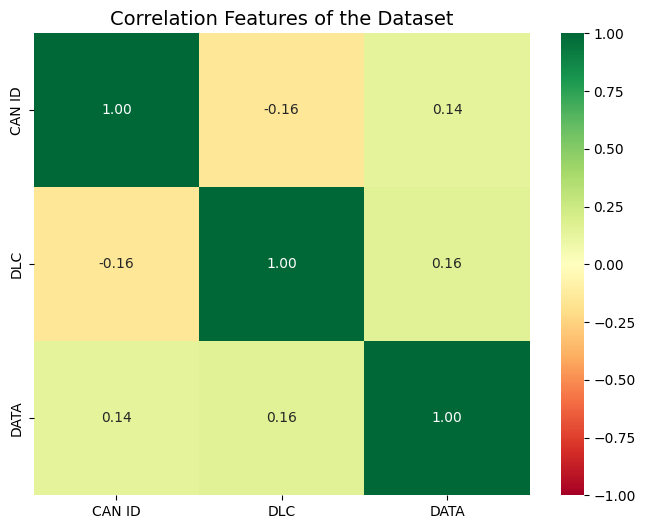

In [ ]:
df = pd.DataFrame(all_data[['CAN ID', 'DLC', 'DATA']])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn", fmt=".2f", vmin=-1, vmax=1)

# Add labels and title
plt.title("Correlation Features of the Dataset", fontsize=14)
plt.show()


# CNN with 2 labels

In [ ]:
# Update labels: 0 to 3 -> 0, and 4 -> 1
y_train_binary = np.where(y_train <= 3, 0, 1)
y_val_binary = np.where(y_val <= 3, 0, 1)
y_test_binary = np.where(y_test <= 3, 0, 1)


In [ ]:
# Optimization parameters
patience = 3
verbose = 1
factor = 0.5
lr = 0.00001
epochs = 20
batch_size = 64

# Create the learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=verbose, min_lr=lr)

# Create a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=verbose)

# Build the CNN model
model = Sequential()
# Adjust the input shape to match the input data's shape
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same', input_shape=(1, 3)))
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same'))
model.add(Flatten())  # Flatten the output of Conv1D layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer for classification


# Compile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train_binary,
    batch_size=batch_size,
    steps_per_epoch=X_train_reshaped.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_reshaped, y_val_binary),
    callbacks=[learning_rate_reduction, checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(X_test_reshaped, y_test_binary, verbose=0)
print(f"CNN Model Accuracy: {evaluation[1] * 100:.2f}%")


Epoch 1/20
7648/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 3402.2534
Epoch 1: val_loss improved from inf to 0.12657, saving model to best_model.keras
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9696 - loss: 3401.8916 - val_accuracy: 0.9681 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 2/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 2:07:45 1s/step - accuracy: 0.9615 - loss: 0.0541
Epoch 2: val_loss did not improve from 0.12657
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 3s 211us/step - accuracy: 0.9615 - loss: 0.0541 - val_accuracy: 0.9681 - val_loss: 0.1270 - learning_rate: 0.0010
Epoch 3/20
7650/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9674 - loss: 4.9229
Epoch 3: val_loss did not improve from 0.12657
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9674 - loss: 4.9198 - val_accuracy: 0.9681 - val_loss: 0.1415 - learning_rate: 0.0010
Epoch 4/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9615 - loss: 0.1631
Epoch 4: ReduceLROnPlateau re

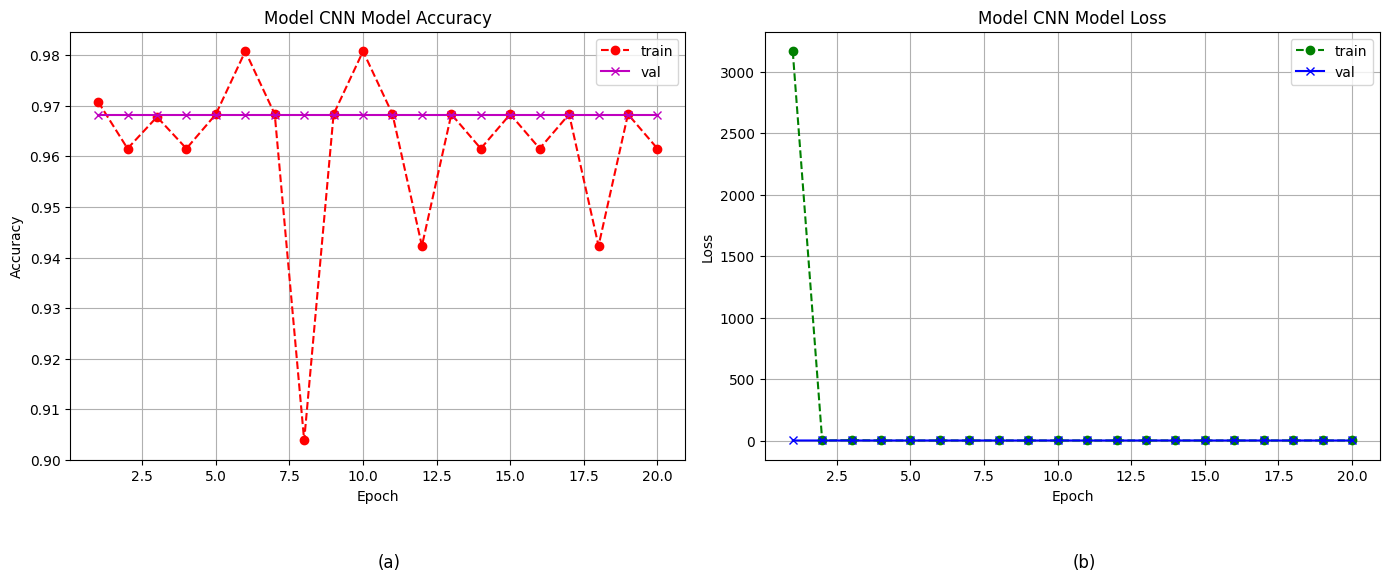

In [ ]:
# Extract accuracy and loss values
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_acc, 'r--', marker='o', label='train')
plt.plot(epochs, val_acc, 'm-', marker='x', label='val')
plt.title('Model CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.annotate('(a)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'g--', marker='o', label='train')
plt.plot(epochs, val_loss, 'b-', marker='x', label='val')
plt.title('Model CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.annotate('(b)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report for each class
report = classification_report(y_test_binary, y_pred_classes, target_names=['Attack 0', 'Normal'], output_dict=True)

# Format the results
precision_normal = report['Normal']['precision'] * 100
recall_normal = report['Normal']['recall'] * 100
f1_normal = report['Normal']['f1-score'] * 100

precision_attacks = [report[f'Attack {i}']['precision'] * 100 for i in range(1)]
recall_attacks = [report[f'Attack {i}']['recall'] * 100 for i in range(1)]
f1_attacks = [report[f'Attack {i}']['f1-score'] * 100 for i in range(1)]

# Calculate the accuracy
accuracy = report['accuracy'] * 100

# Calculate the weighted average
weighted_precision = report['weighted avg']['precision'] * 100
weighted_recall = report['weighted avg']['recall'] * 100
weighted_f1 = report['weighted avg']['f1-score'] * 100


7660/7660 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


In [ ]:
# Create the results table
results = {
    'Dataset': ['Normal'] + ['Attacks'] + ['Accuracy', 'Weighted average'],
    'Precision (%)': [precision_normal] + precision_attacks + [98.61, weighted_precision],
    'Recall (%)': [recall_normal] + recall_attacks + [98.61, weighted_recall],
    'F1-Score (%)': [f1_normal] + f1_attacks + [98.61, weighted_f1],
}

results_df = pd.DataFrame(results)

# Print the results table
results_df


,Dataset,Precision (%),Recall (%),F1-Score (%)
0,Normal,96.876568,100.000000,98.413508
1,Attacks,0.000000,0.000000,0.000000
2,Accuracy,98.610000,98.610000,98.610000
3,Weighted average,93.850695,96.876568,95.339629


# CNN-LSTM with 5 labels

In [ ]:
# Input shape
input_shape = (3, 1)  # Update to match your data

# Reshape data
X_train_reshaped = X_train.reshape(-1, 3, 1)
X_val_reshaped = X_val.reshape(-1, 3, 1)
X_test_reshaped = X_test.reshape(-1, 3, 1)


# Input layer
inp = Input(shape=input_shape)

# First Conv1D block
C = Conv1D(filters=32, kernel_size=1, strides=1)(inp)
C2 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(C)
A1 = Activation("relu")(C2)

# Residual connection
C3 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(A1)
S1 = Add()([C3, C])
A2 = Activation("relu")(S1)

# MaxPooling
M1 = MaxPooling1D(pool_size=1, strides=2)(A2)

# Second Conv1D block
C4 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(M1)
A3 = Activation("relu")(C4)

# Residual connection
C5 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(A3)
S2 = Add()([C5, M1])
A4 = Activation("relu")(S2)

# MaxPooling
M2 = MaxPooling1D(pool_size=1, strides=2)(A4)

# Third Conv1D block
C6 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(M2)
A5 = Activation("relu")(C6)

# Residual connection
C7 = Conv1D(filters=32, kernel_size=1, strides=1, padding='same')(A5)
S3 = Add()([C7, M2])
A6 = Activation("relu")(S3)

# MaxPooling
M3 = MaxPooling1D(pool_size=1, strides=2)(A6)

# Flatten and Dense layers
F = Flatten()(M3)
D1 = Dense(32)(F)
A7 = Activation("relu")(D1)
D1_dropout = Dropout(0.3)(A7)  # Add dropout layer
D2 = Dense(32)(D1_dropout)
D3 = Dense(len(np.unique(y)))(D2)
A8 = Activation("softmax")(D3)

# Create the model
model = Model(inputs=inp, outputs=A8)

# Compile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    batch_size=64,
    steps_per_epoch=X_train_reshaped.shape[0] // 64,
    epochs=20,  # Updated to match the structure
    validation_data=(X_val_reshaped, y_val),
    callbacks=[learning_rate_reduction, checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Updated CNN-LSTM Model Accuracy: {evaluation[1] * 100:.2f}%")


Epoch 1/20
7648/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9685 - loss: 2260.1003
Epoch 1: val_loss improved from inf to 0.23640, saving model to best_model.keras
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.9685 - loss: 2257.0933 - val_accuracy: 0.9841 - val_loss: 0.2364 - learning_rate: 0.0010
Epoch 2/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 4:47:00 2s/step - accuracy: 1.0000 - loss: 0.0045
Epoch 2: val_loss did not improve from 0.23640
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 5s 390us/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9841 - val_loss: 0.2364 - learning_rate: 0.0010
Epoch 3/20
7644/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 363.6579
Epoch 3: val_loss improved from 0.23640 to 0.09502, saving model to best_model.keras
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9803 - loss: 363.7970 - val_accuracy: 0.9841 - val_loss: 0.0950 - learning_rate: 0.0010
Epoch 4/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 1.0000 - 

In [ ]:
# Splitting features and labels
X = all_data[['CAN ID', 'DLC', 'DATA']].values.astype(np.float32)
y = all_data['Encoded_Label'].values.astype(np.int32)


# Splitting the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.75, random_state=42)

# Reshape input data for CNN-LSTM
# Input shape: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Shape: (num_samples, timesteps=1, features=2)
X_val_reshaped = np.expand_dims(X_val, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

In [ ]:
# Optimization parameters
patience = 3
verbose = 1
factor = 0.5
lr = 0.00001
epochs = 20
batch_size = 64

# Create the learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=verbose, min_lr=lr)

# Create a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=verbose)

# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same', input_shape=(1, X_train.shape[1])))
# model.add(Dropout(0.5))  # Dropout after the first Conv1D
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same'))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, return_sequences=False))  # Outputs a flattened sequence
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer for classification

# Compile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    batch_size=batch_size,
    steps_per_epoch=X_train_reshaped.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[learning_rate_reduction, checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"CNN-LSTM Model Accuracy: {evaluation[1] * 100:.2f}%")


Epoch 1/20
7652/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9815 - loss: 0.1084
Epoch 1: val_loss improved from inf to 0.05744, saving model to best_model.keras
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step - accuracy: 0.9815 - loss: 0.1084 - val_accuracy: 0.9841 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 2/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 13:36 107ms/step - accuracy: 0.9615 - loss: 0.0845
Epoch 2: val_loss did not improve from 0.05744
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 5s 589us/step - accuracy: 0.9615 - loss: 0.0845 - val_accuracy: 0.9841 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 3/20
7652/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9842 - loss: 0.0851
Epoch 3: val_loss did not improve from 0.05744
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - accuracy: 0.9842 - loss: 0.0851 - val_accuracy: 0.9841 - val_loss: 0.0954 - learning_rate: 0.0010
Epoch 4/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 1:34 12ms/step - accuracy: 1.0000 - loss: 0.0120
Epoch 4: ReduceLROnPlateau reduc

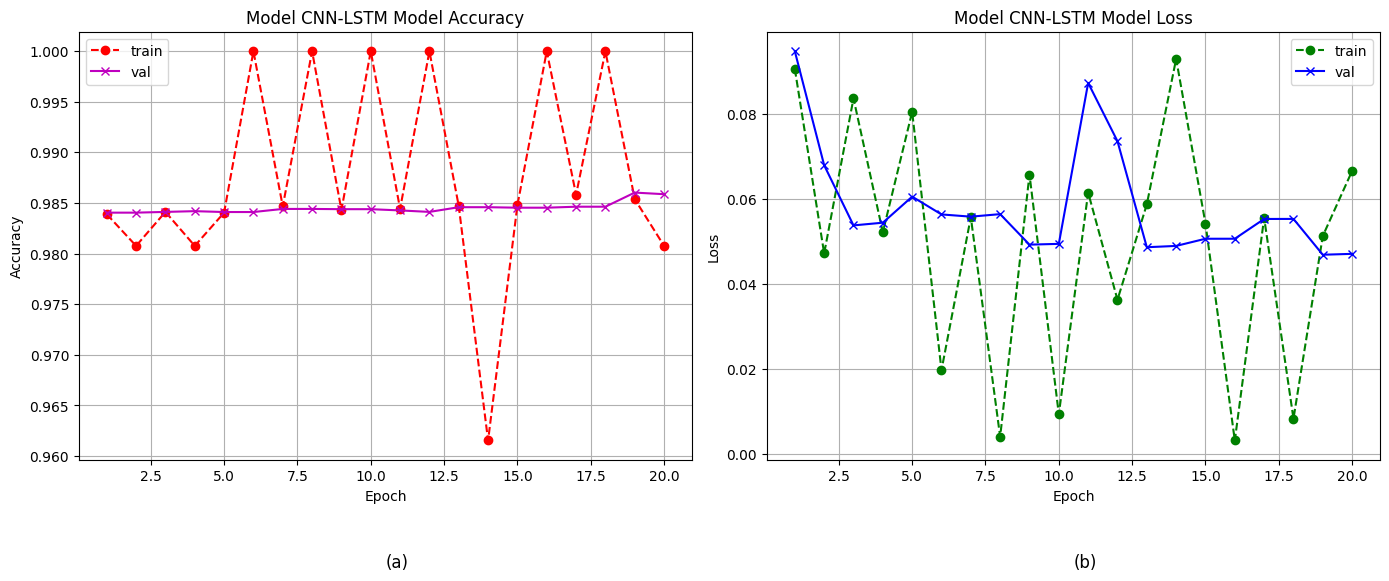

In [ ]:
# Extract accuracy and loss values
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_acc, 'r--', marker='o', label='train')
plt.plot(epochs, val_acc, 'm-', marker='x', label='val')
plt.title('Model CNN-LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.annotate('(a)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'g--', marker='o', label='train')
plt.plot(epochs, val_loss, 'b-', marker='x', label='val')
plt.title('Model CNN-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.annotate('(b)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report for each class
report = classification_report(y_test, y_pred_classes, target_names=['Attack 0', 'Attack 1', 'Attack 2', 'Attack 3', 'Normal'], output_dict=True)

# Format the results
precision_normal = report['Normal']['precision'] * 100
recall_normal = report['Normal']['recall'] * 100
f1_normal = report['Normal']['f1-score'] * 100

precision_attacks = [report[f'Attack {i}']['precision'] * 100 for i in range(4)]
recall_attacks = [report[f'Attack {i}']['recall'] * 100 for i in range(4)]
f1_attacks = [report[f'Attack {i}']['f1-score'] * 100 for i in range(4)]

# Calculate the accuracy
accuracy = report['accuracy'] * 100

# Calculate the weighted average
weighted_precision = report['weighted avg']['precision'] * 100
weighted_recall = report['weighted avg']['recall'] * 100
weighted_f1 = report['weighted avg']['f1-score'] * 100


7660/7660 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


In [ ]:
# Create the results table
results = {
    'Dataset': ['Normal'] + ['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks'] + ['Accuracy', 'Weighted average'],
    'Precision (%)': [precision_normal] + precision_attacks + [98.61, weighted_precision],
    'Recall (%)': [recall_normal] + recall_attacks + [98.61, weighted_recall],
    'F1-Score (%)': [f1_normal] + f1_attacks + [98.61, weighted_f1],
}

results_df = pd.DataFrame(results)

# Print the results table
results_df


,Dataset,Precision (%),Recall (%),F1-Score (%)
0,Normal,98.676078,99.907352,99.287898
1,Flood attacks,100.000000,100.000000,100.000000
2,Fuzzing,75.577558,30.171278,43.126177
3,Replaying attacks,0.000000,0.000000,0.000000
4,Spoofing attacks,0.000000,0.000000,0.000000
5,Accuracy,98.610000,98.610000,98.610000
6,Weighted average,97.839842,98.610856,98.131095


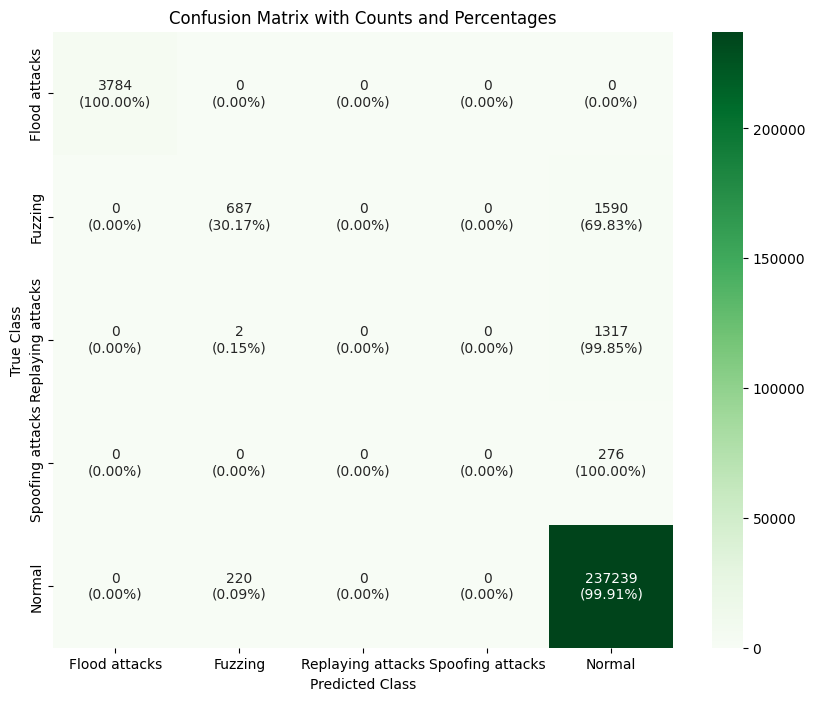

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.2f}%)"

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt="", cmap="Greens", xticklabels=['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks', 'Normal'], yticklabels=['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks', 'Normal'])

plt.title('Confusion Matrix with Counts and Percentages')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
y_pred_probs = model.predict(X_test_reshaped)

# Binarize the test labels for multi-class ROC
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

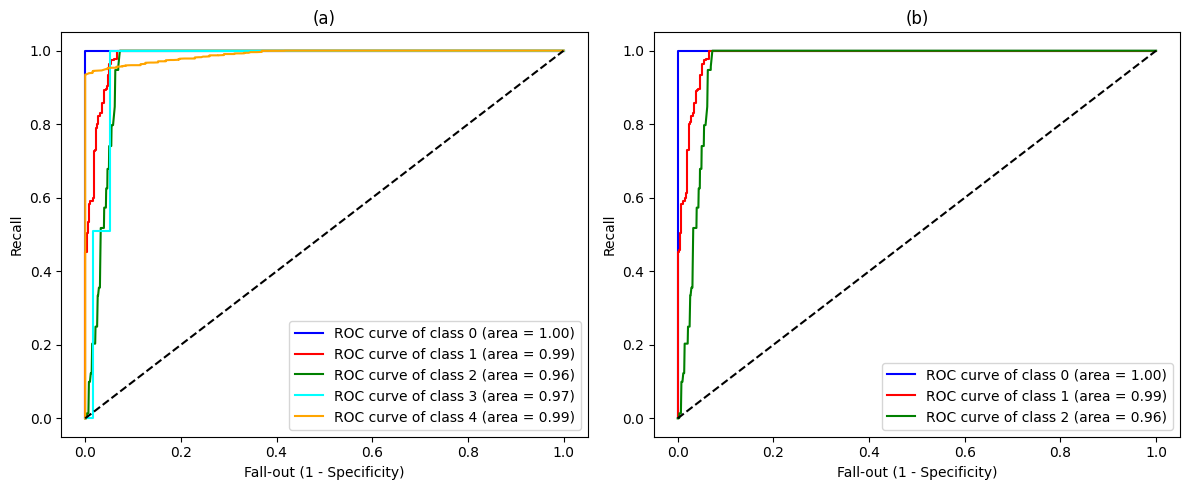

In [ ]:
# Define colors for different classes
colors = ['blue', 'red', 'green', 'cyan', 'orange']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curves for each class in subplot (a)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color=colors[i], label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--')  # Random classifier diagonal
axes[0].set_xlabel('Fall-out (1 - Specificity)')
axes[0].set_ylabel('Recall')
axes[0].set_title('(a)')
axes[0].legend(loc='lower right')

# Plot ROC curves for a subset of classes in subplot (b) (e.g., first three classes)
for i in range(min(3, n_classes)):  # Limit to 3 classes if available
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=colors[i], label=f'ROC curve of class {i} (area = {roc_auc:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--')  # Random classifier diagonal
axes[1].set_xlabel('Fall-out (1 - Specificity)')
axes[1].set_ylabel('Recall')
axes[1].set_title('(b)')
axes[1].legend(loc='lower right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# CNN-LSTM with 3 labels

In [ ]:
all_data = all_data[~all_data['Label'].isin(['Spoofing attacks', 'Replaying attacks'])]
# Encoding Labels
label_encoder = LabelEncoder()
all_data['Encoded_Label'] = label_encoder.fit_transform(all_data['Label'])

all_data['CAN ID'] = all_data['CAN ID'].apply(
    lambda x: int(x.replace(' ', ''), 16) if isinstance(x, str) else x
)

all_data['CAN ID'] = all_data['CAN ID'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
# Splitting features and labels
X = all_data[['CAN ID', 'DLC', 'DATA']].values.astype(np.float32)
y = all_data['Encoded_Label'].values.astype(np.int32)


# Splitting the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.75, random_state=42)

# Reshape input data for CNN-LSTM
# Input shape: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Shape: (num_samples, timesteps=1, features=2)
X_val_reshaped = np.expand_dims(X_val, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

In [ ]:
all_data['Label'].value_counts()

,count
Label,
benign,791260
Flood attacks,12885
Fuzzing,7509


In [ ]:
all_data['Encoded_Label'].value_counts()


,count
Encoded_Label,
2,791260
0,12885
1,7509


In [ ]:
# Optimization parameters
patience = 3
verbose = 1
factor = 0.5
lr = 0.00001
epochs = 20
batch_size = 64

# Create the learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=verbose, min_lr=lr)

# Create a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=verbose)

# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same', input_shape=(1, X_train.shape[1])))
# model.add(Dropout(0.5))  # Dropout after the first Conv1D
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same'))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, return_sequences=False))  # Outputs a flattened sequence
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer for classification

# Compile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    batch_size=batch_size,
    steps_per_epoch=X_train_reshaped.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[learning_rate_reduction, checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"CNN-LSTM Model Accuracy: {evaluation[1] * 100:.2f}%")


Epoch 1/20
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9883 - loss: 0.0602
Epoch 1: val_loss improved from inf to 0.05370, saving model to best_model.keras
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 105s 13ms/step - accuracy: 0.9883 - loss: 0.0602 - val_accuracy: 0.9905 - val_loss: 0.0537 - learning_rate: 0.0010
Epoch 2/20
   1/7609 ━━━━━━━━━━━━━━━━━━━━ 14:49 117ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 2: val_loss did not improve from 0.05370
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 6s 788us/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9905 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 3/20
7607/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9905 - loss: 0.0463
Epoch 3: val_loss improved from 0.05370 to 0.05337, saving model to best_model.keras
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 97s 13ms/step - accuracy: 0.9905 - loss: 0.0463 - val_accuracy: 0.9906 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 4/20
   1/7609 ━━━━━━━━━━━━━━━━━━━━ 2:09 17ms/step - accuracy: 1.0000 - lo

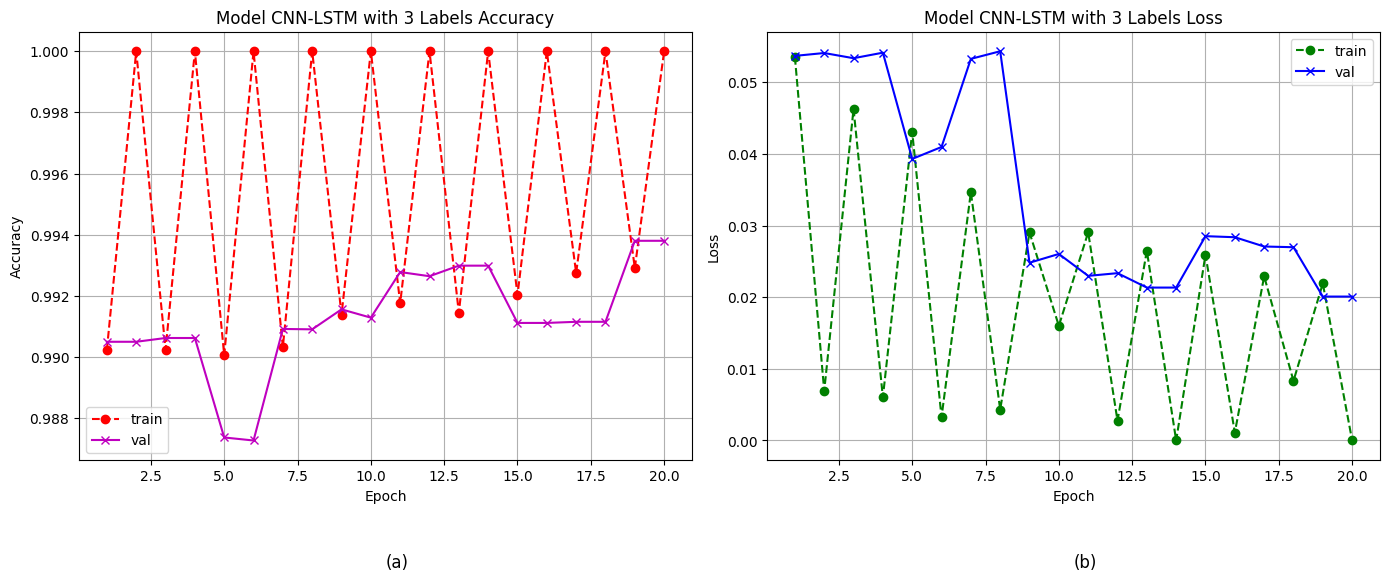

In [ ]:
# Extract accuracy and loss values
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_acc, 'r--', marker='o', label='train')
plt.plot(epochs, val_acc, 'm-', marker='x', label='val')
plt.title('Model CNN-LSTM with 3 Labels Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.annotate('(a)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'g--', marker='o', label='train')
plt.plot(epochs, val_loss, 'b-', marker='x', label='val')
plt.title('Model CNN-LSTM with 3 Labels Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.annotate('(b)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report for each class
report = classification_report(y_test, y_pred_classes, target_names=['Attack 0', 'Attack 1', 'Normal'], output_dict=True)

# Format the results
precision_normal = report['Normal']['precision'] * 100
recall_normal = report['Normal']['recall'] * 100
f1_normal = report['Normal']['f1-score'] * 100

precision_attacks = [report[f'Attack {i}']['precision'] * 100 for i in range(2)]
recall_attacks = [report[f'Attack {i}']['recall'] * 100 for i in range(2)]
f1_attacks = [report[f'Attack {i}']['f1-score'] * 100 for i in range(2)]

# Calculate the accuracy
accuracy = report['accuracy'] * 100

# Calculate the weighted average
weighted_precision = report['weighted avg']['precision'] * 100
weighted_recall = report['weighted avg']['recall'] * 100
weighted_f1 = report['weighted avg']['f1-score'] * 100

# Create the results table
results = {
    'Dataset': ['Normal'] + ['Flood attacks', 'Fuzzing'] + ['Accuracy', 'Weighted average'],
    'Precision (%)': [precision_normal] + precision_attacks + [99.39, weighted_precision],
    'Recall (%)': [recall_normal] + recall_attacks + [99.39, weighted_recall],
    'F1-Score (%)': [f1_normal] + f1_attacks + [99.39, weighted_f1],
}

results_df = pd.DataFrame(results)

# Print the results table
results_df


7610/7610 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


,Dataset,Precision (%),Recall (%),F1-Score (%)
0,Normal,99.407275,99.965458,99.685585
1,Flood attacks,100.000000,100.000000,100.000000
2,Fuzzing,91.449426,38.263525,53.952630
3,Accuracy,99.390000,99.390000,99.390000
4,Weighted average,99.341644,99.385208,99.260028


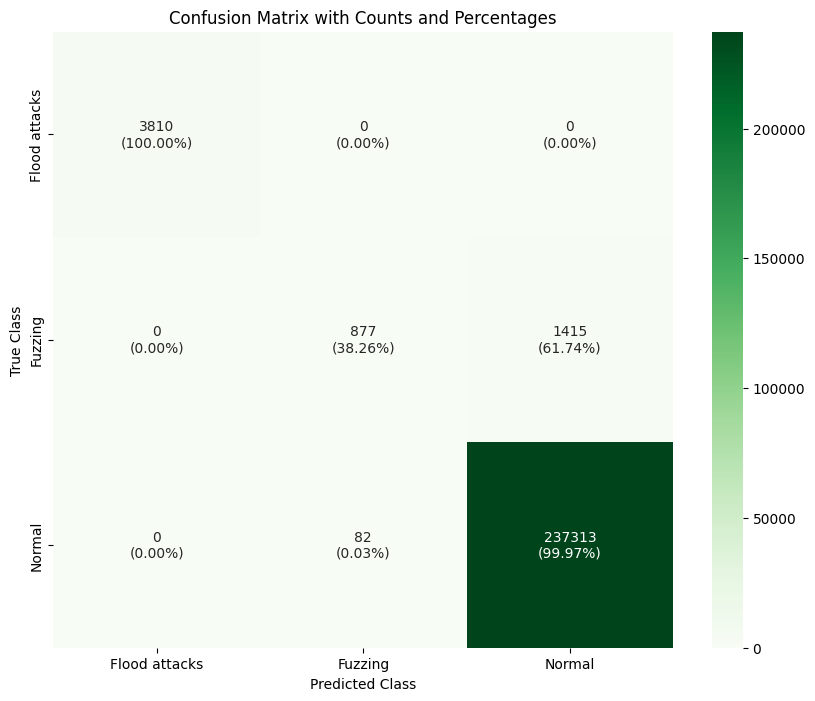

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.2f}%)"

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt="", cmap="Greens", xticklabels=['Flood attacks', 'Fuzzing', 'Normal'], yticklabels=['Flood attacks', 'Fuzzing', 'Normal'])

plt.title('Confusion Matrix with Counts and Percentages')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


# Improvements (Attention Mechanism with 5 Labels)

In [ ]:
# Ensure GPU is used
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU for processing.")
else:
    print("GPU not found. Defaulting to CPU.")

# File paths for datasets
datasets = {
    "DoS_dataset.csv": {"path": "DoS_dataset.csv", "rows": 38657, "label": "Flood attacks"},
    "Fuzzy_dataset.csv": {"path": "Fuzzy_dataset.csv", "rows": 22527, "label": "Fuzzing"},
    "RPM_dataset.csv": {"path": "RPM_dataset.csv", "rows": 1445, "label": "Spoofing attacks"},
    "Replay_dataset_HY_Sonata_train.csv": {"path": "Replay_dataset_HY_Sonata_train.csv", "rows": 13294, "label": "Replaying attacks"},
    "gear_dataset.csv": {"path": "gear_dataset.csv", "rows": 1445, "label": "Spoofing attacks"}
}

# Column names
columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA[0]', 'DATA[1]', 'DATA[2]', 'DATA[3]', 'DATA[4]', 'DATA[5]', 'DATA[6]', 'DATA[7]', 'Flag']
replay_columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA[0]', 'Flag']

# Function to load datasets ensuring a balance of T and R flags
# while ensuring the total rows meet the required amount
def load_balanced_dataset(details, is_replay=False):
    df = pd.read_csv(details["path"], names=(replay_columns if is_replay else columns), header=None)
    t_flags = df[df['Flag'] == 'T']
    r_flags = df[df['Flag'] == 'R']

    # Ensure we have enough T flags and balance R flags to meet row requirements
    num_t_needed = min(len(t_flags), details["rows"] // 3)
    num_r_needed = details["rows"] - num_t_needed

    t_sampled = t_flags.sample(num_t_needed, random_state=42)
    r_sampled = r_flags.sample(num_r_needed, random_state=42)

    balanced_df = pd.concat([t_sampled, r_sampled], axis=0)
    balanced_df["Label"] = balanced_df["Flag"].apply(lambda x: details["label"] if x == "T" else "benign")
    return balanced_df

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Load and label data with balancing
for dataset_name, details in datasets.items():
    is_replay = dataset_name == "Replay_dataset_HY_Sonata_train.csv"
    df = load_balanced_dataset(details, is_replay=is_replay)
    all_data = pd.concat([all_data, df], axis=0)

# Assume normal_run_data_df is preloaded
normal_run_data_df["Label"] = "benign"
all_data = pd.concat([all_data, normal_run_data_df], axis=0)

# Convert DATA columns to a single decimal column
data_columns = ['DATA[0]', 'DATA[1]', 'DATA[2]', 'DATA[3]', 'DATA[4]', 'DATA[5]', 'DATA[6]', 'DATA[7]']

def hex_to_int(row):
    try:
        # Handle Replay dataset directly with DATA[0]
        if 'DATA[1]' not in row:
            return int(row['DATA[0]'], 16)
        # Join the HEX strings and convert to integer for other datasets
        return int(''.join(row[data_columns].astype(str)), 16)
    except ValueError:
        # Handle invalid HEX values by returning 0 or another default value
        return 0

all_data['DATA'] = all_data.apply(hex_to_int, axis=1)
if set(data_columns).issubset(all_data.columns):
    all_data.drop(columns=data_columns, inplace=True)

# Normalize the DATA column
scaler = MinMaxScaler()
all_data['DATA'] = scaler.fit_transform(all_data[['DATA']])

# Encoding Labels
label_encoder = LabelEncoder()
all_data['Encoded_Label'] = label_encoder.fit_transform(all_data['Label'])


Using GPU for processing.


In [ ]:
all_data['CAN ID'] = all_data['CAN ID'].apply(
    lambda x: int(x.replace(' ', ''), 16) if isinstance(x, str) else x
)

all_data['CAN ID'] = all_data['CAN ID'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
# Splitting features and labels
X = all_data[['CAN ID', 'DLC', 'DATA']].values.astype(np.float32)
y = all_data['Encoded_Label'].values.astype(np.int32)


# Splitting the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.75, random_state=42)

# Reshape input data for CNN-LSTM
# Input shape: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Shape: (num_samples, timesteps=1, features=2)
X_val_reshaped = np.expand_dims(X_val, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Calculate attention scores
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=[2, 0]) + self.b)
        a = tf.nn.softmax(e, axis=1)
        # Apply attention weights
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# Optimization parameters
patience = 3
verbose = 1
factor = 0.5
lr = 0.00001
epochs = 20
batch_size = 64

# Create the learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=verbose, min_lr=lr)

# Create a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model_with_attention.keras', monitor='val_loss', save_best_only=True, verbose=verbose)

# Build the CNN-LSTM model with attention
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same', input_shape=(1, X_train.shape[1])))
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same'))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, return_sequences=True))  # Keep return_sequences=True for the Attention layer
model.add(Attention())  # Add the custom Attention layer
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer for classification

# Compile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    batch_size=batch_size,
    steps_per_epoch=X_train_reshaped.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[learning_rate_reduction, checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"CNN-LSTM with Attention Model Accuracy: {evaluation[1] * 100:.2f}%")


Epoch 1/20
7658/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9822 - loss: 0.1015
Epoch 1: val_loss improved from inf to 0.09503, saving model to best_model_with_attention.keras
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 95s 12ms/step - accuracy: 0.9822 - loss: 0.1015 - val_accuracy: 0.9841 - val_loss: 0.0950 - learning_rate: 0.0010
Epoch 2/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 1:26 11ms/step - accuracy: 1.0000 - loss: 0.0122
Epoch 2: val_loss did not improve from 0.09503
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 4s 564us/step - accuracy: 1.0000 - loss: 0.0122 - val_accuracy: 0.9841 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 3/20
7657/7659 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9840 - loss: 0.0905
Epoch 3: val_loss did not improve from 0.09503
7659/7659 ━━━━━━━━━━━━━━━━━━━━ 98s 13ms/step - accuracy: 0.9840 - loss: 0.0905 - val_accuracy: 0.9681 - val_loss: 0.1050 - learning_rate: 0.0010
Epoch 4/20
   1/7659 ━━━━━━━━━━━━━━━━━━━━ 1:37 13ms/step - accuracy: 1.0000 - loss: 0.0223
Epoch 4: Reduce

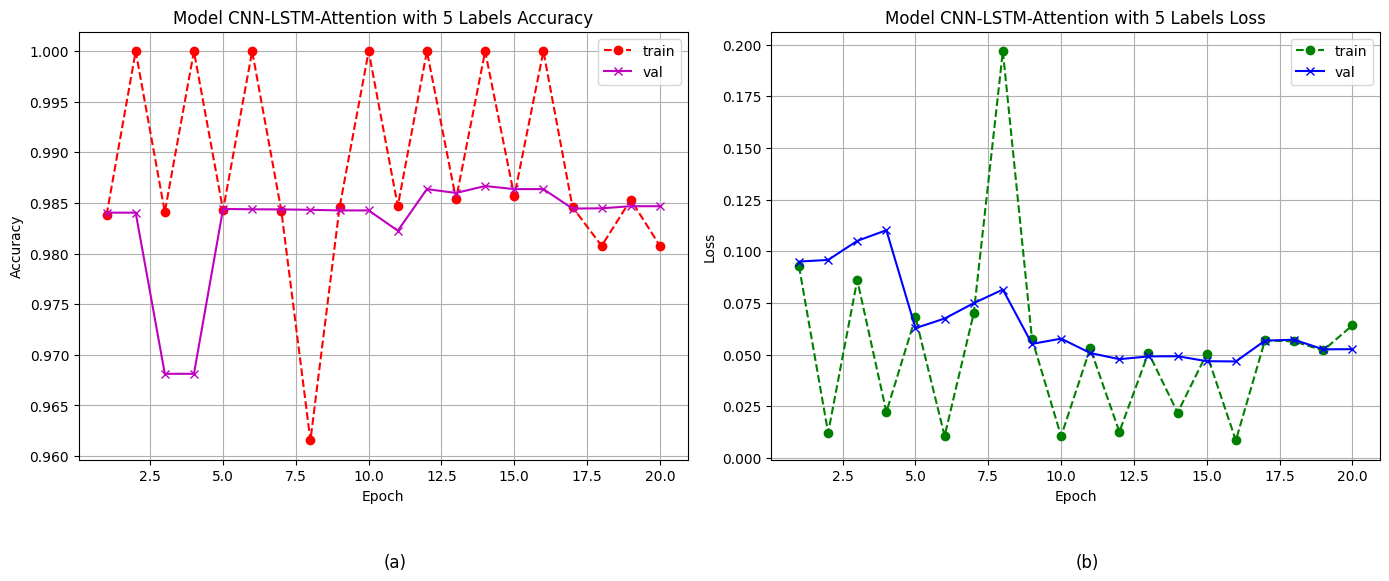

In [ ]:
# Extract accuracy and loss values
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_acc, 'r--', marker='o', label='train')
plt.plot(epochs, val_acc, 'm-', marker='x', label='val')
plt.title('Model CNN-LSTM-Attention with 5 Labels Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.annotate('(a)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'g--', marker='o', label='train')
plt.plot(epochs, val_loss, 'b-', marker='x', label='val')
plt.title('Model CNN-LSTM-Attention with 5 Labels Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.annotate('(b)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report for each class
report = classification_report(y_test, y_pred_classes, target_names=['Attack 0', 'Attack 1', 'Attack 2', 'Attack 3', 'Normal'], output_dict=True)

# Format the results
precision_normal = report['Normal']['precision'] * 100
recall_normal = report['Normal']['recall'] * 100
f1_normal = report['Normal']['f1-score'] * 100

precision_attacks = [report[f'Attack {i}']['precision'] * 100 for i in range(4)]
recall_attacks = [report[f'Attack {i}']['recall'] * 100 for i in range(4)]
f1_attacks = [report[f'Attack {i}']['f1-score'] * 100 for i in range(4)]

# Calculate the accuracy
accuracy = report['accuracy'] * 100

# Calculate the weighted average
weighted_precision = report['weighted avg']['precision'] * 100
weighted_recall = report['weighted avg']['recall'] * 100
weighted_f1 = report['weighted avg']['f1-score'] * 100

# Create the results table
results = {
    'Dataset': ['Normal'] + ['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks'] + ['Accuracy', 'Weighted average'],
    'Precision (%)': [precision_normal] + precision_attacks + [98.49, weighted_precision],
    'Recall (%)': [recall_normal] + recall_attacks + [98.49, weighted_recall],
    'F1-Score (%)': [f1_normal] + f1_attacks + [98.49, weighted_f1],
}

results_df = pd.DataFrame(results)

# Print the results table
results_df


7660/7660 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step


,Dataset,Precision (%),Recall (%),F1-Score (%)
0,Normal,98.466967,100.000000,99.227563
1,Flood attacks,100.000000,100.000000,100.000000
2,Fuzzing,100.000000,7.685551,14.274062
3,Replaying attacks,0.000000,0.000000,0.000000
4,Spoofing attacks,0.000000,0.000000,0.000000
5,Accuracy,98.490000,98.490000,98.490000
6,Weighted average,97.864136,98.491728,97.804622


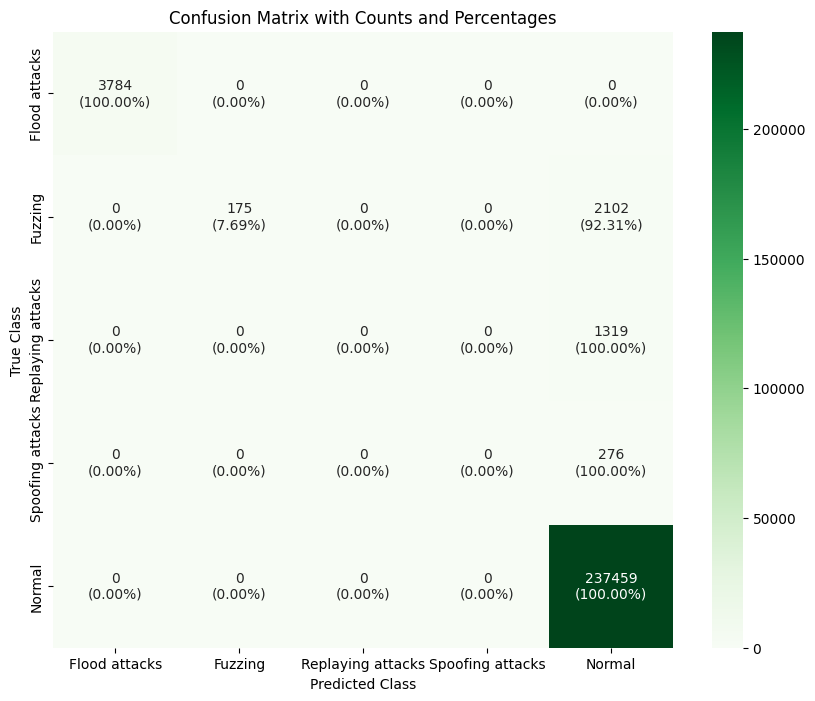

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.2f}%)"

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt="", cmap="Greens", xticklabels=['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks', 'Normal'], yticklabels=['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks', 'Normal'])

plt.title('Confusion Matrix with Counts and Percentages')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


# Improvements (Attention Mechanism with 3 Labels)

In [ ]:
all_data = all_data[~all_data['Label'].isin(['Spoofing attacks', 'Replaying attacks'])]
# Encoding Labels
label_encoder = LabelEncoder()
all_data['Encoded_Label'] = label_encoder.fit_transform(all_data['Label'])

all_data['CAN ID'] = all_data['CAN ID'].apply(
    lambda x: int(x.replace(' ', ''), 16) if isinstance(x, str) else x
)

all_data['CAN ID'] = all_data['CAN ID'].apply(lambda x: int(x, 16) if isinstance(x, str) else x)
# Splitting features and labels
X = all_data[['CAN ID', 'DLC', 'DATA']].values.astype(np.float32)
y = all_data['Encoded_Label'].values.astype(np.int32)


# Splitting the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.75, random_state=42)

# Reshape input data for CNN-LSTM
# Input shape: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Shape: (num_samples, timesteps=1, features=2)
X_val_reshaped = np.expand_dims(X_val, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Calculate attention scores
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=[2, 0]) + self.b)
        a = tf.nn.softmax(e, axis=1)
        # Apply attention weights
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


# Optimization parameters
patience = 3
verbose = 1
factor = 0.5
lr = 0.00001
epochs = 20
batch_size = 64

# Create the learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=verbose, min_lr=lr)

# Create a ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model_with_attention.keras', monitor='val_loss', save_best_only=True, verbose=verbose)

# Build the CNN-LSTM model with attention
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same', input_shape=(1, X_train.shape[1])))
model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding='same'))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, return_sequences=True))  # Keep return_sequences=True for the Attention layer
model.add(Attention())  # Add the custom Attention layer
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))  # Output layer for classification

# Compile the model
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    batch_size=batch_size,
    steps_per_epoch=X_train_reshaped.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[learning_rate_reduction, checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"CNN-LSTM with Attention Model Accuracy: {evaluation[1] * 100:.2f}%")


Epoch 1/20
7607/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9898 - loss: 0.0582
Epoch 1: val_loss improved from inf to 0.03564, saving model to best_model_with_attention.keras
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 94s 12ms/step - accuracy: 0.9898 - loss: 0.0582 - val_accuracy: 0.9905 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 2/20
   1/7609 ━━━━━━━━━━━━━━━━━━━━ 1:42 13ms/step - accuracy: 0.9375 - loss: 0.1416
Epoch 2: val_loss did not improve from 0.03564
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 4s 557us/step - accuracy: 0.9375 - loss: 0.1416 - val_accuracy: 0.9905 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 3/20
7607/7609 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9906 - loss: 0.0405
Epoch 3: val_loss improved from 0.03564 to 0.02744, saving model to best_model_with_attention.keras
7609/7609 ━━━━━━━━━━━━━━━━━━━━ 93s 12ms/step - accuracy: 0.9906 - loss: 0.0405 - val_accuracy: 0.9909 - val_loss: 0.0274 - learning_rate: 0.0010
Epoch 4/20
   1/7609 ━━━━━━━━━━━━━━━━━━━━ 2:00 16ms/s

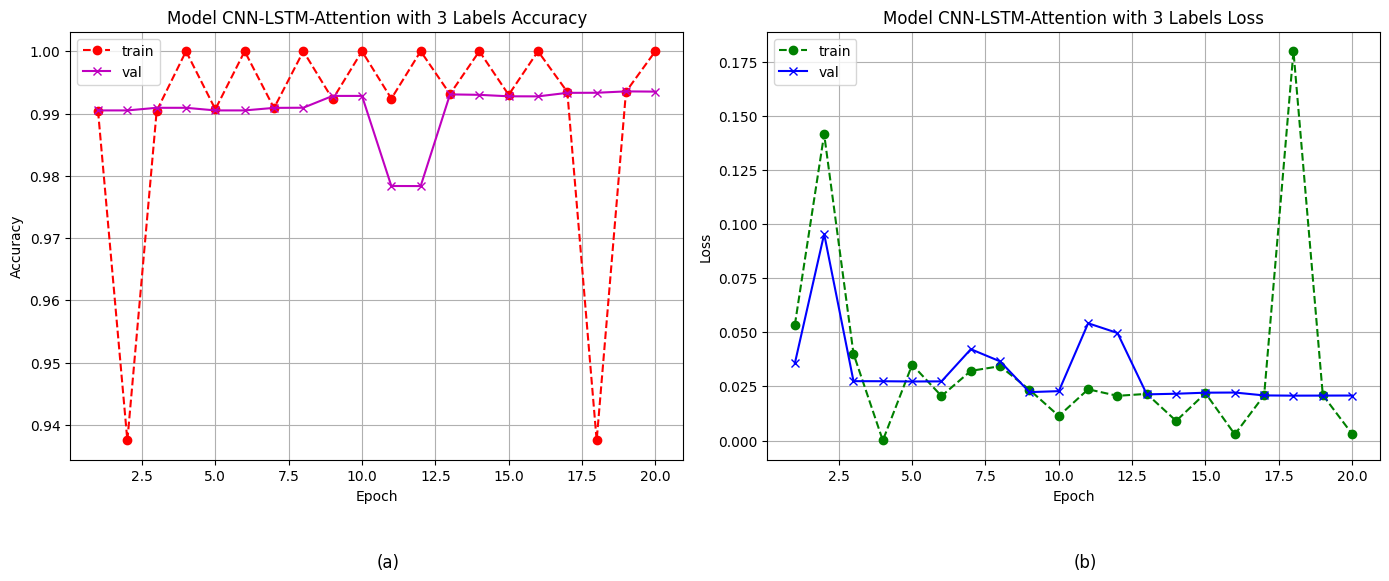

In [ ]:
# Extract accuracy and loss values
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_acc, 'r--', marker='o', label='train')
plt.plot(epochs, val_acc, 'm-', marker='x', label='val')
plt.title('Model CNN-LSTM-Attention with 3 Labels Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.annotate('(a)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'g--', marker='o', label='train')
plt.plot(epochs, val_loss, 'b-', marker='x', label='val')
plt.title('Model CNN-LSTM-Attention with 3 Labels Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.annotate('(b)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report for each class
report = classification_report(y_test, y_pred_classes, target_names=['Attack 0', 'Attack 1', 'Normal'], output_dict=True)

# Format the results
precision_normal = report['Normal']['precision'] * 100
recall_normal = report['Normal']['recall'] * 100
f1_normal = report['Normal']['f1-score'] * 100

precision_attacks = [report[f'Attack {i}']['precision'] * 100 for i in range(2)]
recall_attacks = [report[f'Attack {i}']['recall'] * 100 for i in range(2)]
f1_attacks = [report[f'Attack {i}']['f1-score'] * 100 for i in range(2)]

# Calculate the accuracy
accuracy = report['accuracy'] * 100

# Calculate the weighted average
weighted_precision = report['weighted avg']['precision'] * 100
weighted_recall = report['weighted avg']['recall'] * 100
weighted_f1 = report['weighted avg']['f1-score'] * 100

# Create the results table
results = {
    'Dataset': ['Normal'] + ['Flood attacks', 'Fuzzing'] + ['Accuracy', 'Weighted average'],
    'Precision (%)': [precision_normal] + precision_attacks + [99.39, weighted_precision],
    'Recall (%)': [recall_normal] + recall_attacks + [99.39, weighted_recall],
    'F1-Score (%)': [f1_normal] + f1_attacks + [99.39, weighted_f1],
}

results_df = pd.DataFrame(results)

# Print the results table
results_df


7610/7610 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step


,Dataset,Precision (%),Recall (%),F1-Score (%)
0,Normal,99.377238,99.954927,99.665246
1,Flood attacks,100.000000,100.000000,100.000000
2,Fuzzing,88.267544,35.122164,50.249688
3,Accuracy,99.390000,99.390000,99.390000
4,Weighted average,99.282408,99.345372,99.205342


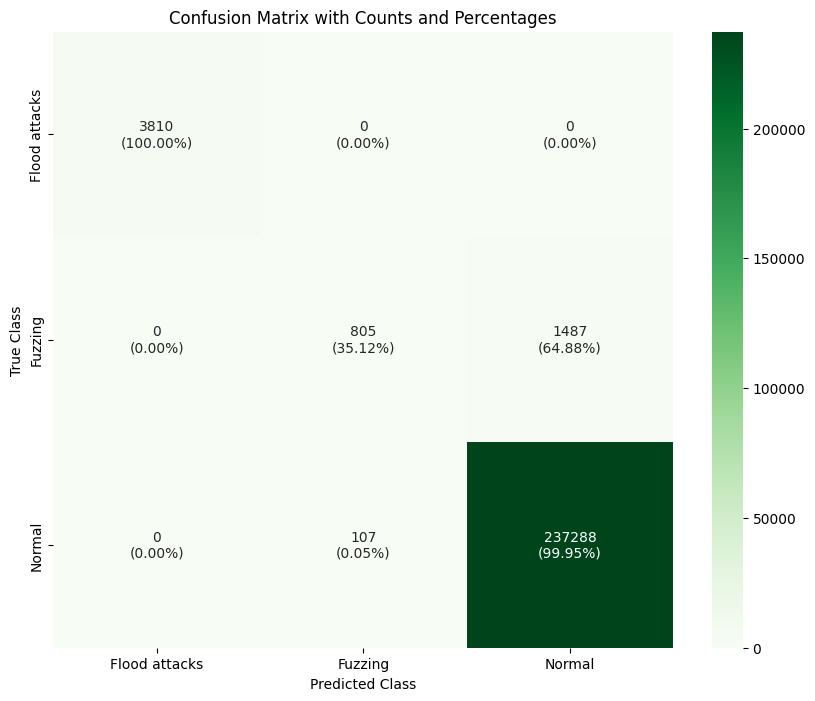

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.2f}%)"

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt="", cmap="Greens", xticklabels=['Flood attacks', 'Fuzzing', 'Normal'], yticklabels=['Flood attacks', 'Fuzzing', 'Normal'])

plt.title('Confusion Matrix with Counts and Percentages')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


# Improvements (Transformer model)

In [ ]:
# Data Preparation (your provided code)
X = all_data[['CAN ID', 'DLC', 'DATA']].values.astype(np.float32)
y = all_data['Encoded_Label'].values.astype(np.int32)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.75, random_state=42)

# Reshape input data for Transformer
X_train_reshaped = np.expand_dims(X_train, axis=1)  # Shape: (num_samples, timesteps=1, features=3)
X_val_reshaped = np.expand_dims(X_val, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = Add()([attention, inputs])  # Residual connection
    attention = LayerNormalization(epsilon=1e-6)(attention)

    # Feed-forward network
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Add()([ff, attention])  # Residual connection
    ff = LayerNormalization(epsilon=1e-6)(ff)

    return ff

# Build the Transformer Model
input_layer = Input(shape=(1, X_train.shape[1]))  # Input shape: (timesteps=1, features=3)
x = transformer_encoder(input_layer, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = GlobalAveragePooling1D()(x)  # Reduce the sequence dimension
x = Dense(128, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(256, activation="relu")(x)
output_layer = Dense(len(np.unique(y)), activation="softmax")(x)  # Output layer for classification

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint("transformer_model.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[learning_rate_reduction, checkpoint]
)

# Evaluate the model
evaluation = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Transformer Model Accuracy: {evaluation[1] * 100:.2f}%")


Epoch 1/20
7660/7660 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9806 - loss: 0.1133
Epoch 1: val_loss improved from inf to 0.09604, saving model to transformer_model.keras
7660/7660 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.9806 - loss: 0.1133 - val_accuracy: 0.9841 - val_loss: 0.0960 - learning_rate: 0.0010
Epoch 2/20
7647/7660 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9845 - loss: 0.0942
Epoch 2: val_loss improved from 0.09604 to 0.09501, saving model to transformer_model.keras
7660/7660 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9845 - loss: 0.0942 - val_accuracy: 0.9841 - val_loss: 0.0950 - learning_rate: 0.0010
Epoch 3/20
7653/7660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9840 - loss: 0.0961
Epoch 3: val_loss did not improve from 0.09501
7660/7660 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9840 - loss: 0.0961 - val_accuracy: 0.9841 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 4/20
7648/7660 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - lo

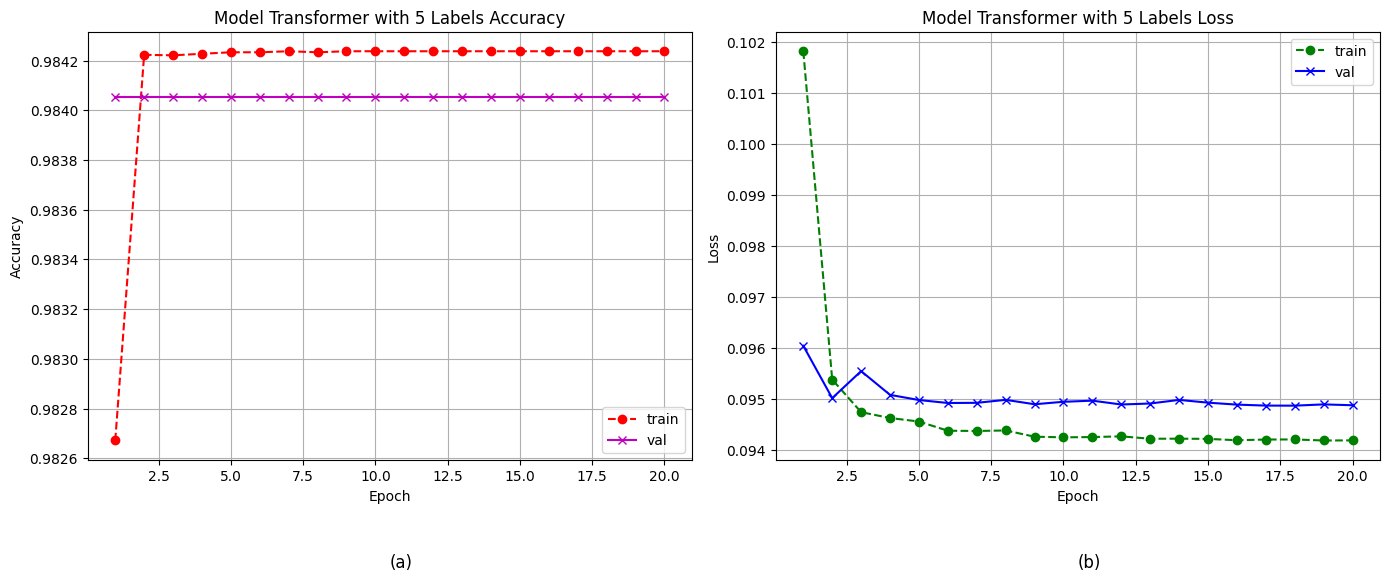

In [ ]:
# Extract accuracy and loss values
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(epochs, train_acc, 'r--', marker='o', label='train')
plt.plot(epochs, val_acc, 'm-', marker='x', label='val')
plt.title('Model Transformer with 5 Labels Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.annotate('(a)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'g--', marker='o', label='train')
plt.plot(epochs, val_loss, 'b-', marker='x', label='val')
plt.title('Model Transformer with 5 Labels Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.annotate('(b)', xy=(0.5, -0.25), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Print classification report for each class
report = classification_report(y_test, y_pred_classes, target_names=['Attack 0', 'Attack 1', 'Attack 2', 'Attack 3', 'Normal'], output_dict=True)

# Format the results
precision_normal = report['Normal']['precision'] * 100
recall_normal = report['Normal']['recall'] * 100
f1_normal = report['Normal']['f1-score'] * 100

precision_attacks = [report[f'Attack {i}']['precision'] * 100 for i in range(4)]
recall_attacks = [report[f'Attack {i}']['recall'] * 100 for i in range(4)]
f1_attacks = [report[f'Attack {i}']['f1-score'] * 100 for i in range(4)]

# Calculate the accuracy
accuracy = report['accuracy'] * 100

# Calculate the weighted average
weighted_precision = report['weighted avg']['precision'] * 100
weighted_recall = report['weighted avg']['recall'] * 100
weighted_f1 = report['weighted avg']['f1-score'] * 100

# Create the results table
results = {
    'Dataset': ['Normal'] + ['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks'] + ['Accuracy', 'Weighted average'],
    'Precision (%)': [precision_normal] + precision_attacks + [98.49, weighted_precision],
    'Recall (%)': [recall_normal] + recall_attacks + [98.49, weighted_recall],
    'F1-Score (%)': [f1_normal] + f1_attacks + [98.49, weighted_f1],
}

results_df = pd.DataFrame(results)

# Print the results table
results_df


7660/7660 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step


,Dataset,Precision (%),Recall (%),F1-Score (%)
0,Normal,98.395565,100.000000,99.191295
1,Flood attacks,100.000000,100.000000,100.000000
2,Fuzzing,0.000000,0.000000,0.000000
3,Replaying attacks,0.000000,0.000000,0.000000
4,Spoofing attacks,0.000000,0.000000,0.000000
5,Accuracy,98.490000,98.490000,98.490000
6,Weighted average,96.866011,98.420333,97.636887


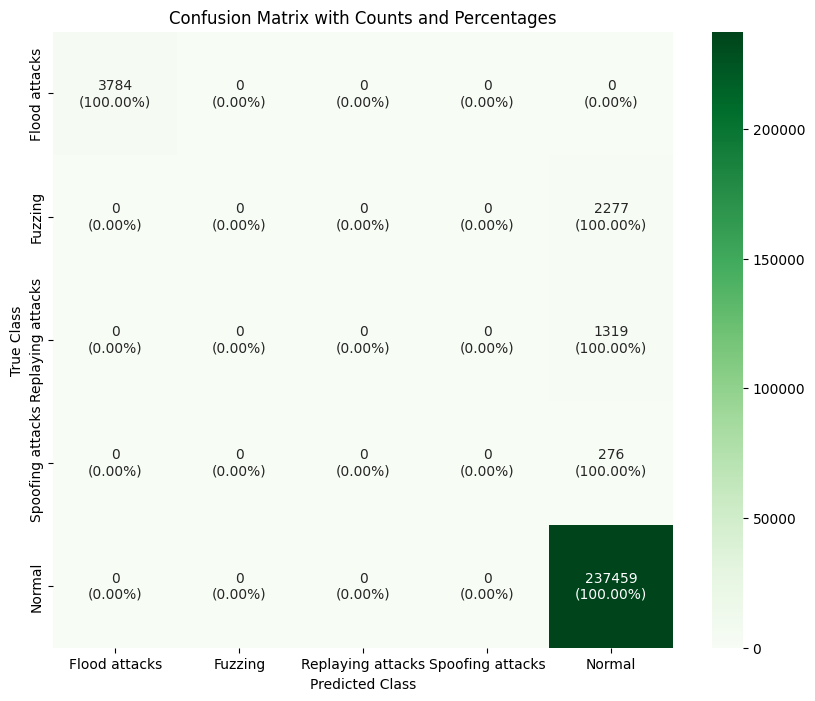

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create annotations with counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.2f}%)"

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt="", cmap="Greens", xticklabels=['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks', 'Normal'], yticklabels=['Flood attacks', 'Fuzzing', 'Replaying attacks', 'Spoofing attacks', 'Normal'])

plt.title('Confusion Matrix with Counts and Percentages')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


# Final Reports

In [ ]:
# Define the data
data = {
    'Models': ['CNN', 'CNN-LSTM', 'CNN-LSTM', 'CNN-LSTM-Attention', 'CNN-LSTM-Attention', 'Transformer'],
    'Labels': ['Two', 'Five', 'Three', 'Five', 'Three', 'Five'],
    'Precision (%)': [93.85, 97.83, 99.34, 97.86, 99.28, 96.86],
    'Recall (%)': [96.87, 98.61, 99.38, 98.49, 99.34, 98.42],
    'F1-Score (%)': [95.33, 98.13, 99.26, 97.80, 99.20, 97.63],
    'Accuracy (%)': [96.88, 98.61, 99.39, 98.49, 99.35, 98.42]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df

,Models,Labels,Precision (%),Recall (%),F1-Score (%),Accuracy (%)
0,CNN,Two,93.85,96.87,95.33,96.88
1,CNN-LSTM,Five,97.83,98.61,98.13,98.61
2,CNN-LSTM,Three,99.34,99.38,99.26,99.39
3,CNN-LSTM-Attention,Five,97.86,98.49,97.80,98.49
4,CNN-LSTM-Attention,Three,99.28,99.34,99.20,99.35
5,Transformer,Five,96.86,98.42,97.63,98.42


# Improvement (Random Forest)

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define target class names
class_names = ["Flood attacks", "Fuzzing", "Replaying attacks", "Spoofing attacks", "Benign"]

# Train Random Forest (assuming all_data is preprocessed)
X = all_data[['CAN ID', 'DLC', 'DATA']].values.astype(np.float32)
y = all_data['Encoded_Label'].values.astype(np.int32)

# Splitting the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.75, random_state=42, stratify=y_temp)

# Initialize and train Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=15, random_state=42, class_weight="balanced")
rf_clf.fit(X_train, y_train)

# Predictions
y_pred_test = rf_clf.predict(X_test)

# Classification Report
report_dict = classification_report(y_test, y_pred_test, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
print("\nClassification Report:\n")
df_report



Classification Report:



,precision,recall,f1-score,support
Flood attacks,1.000000,1.000000,1.000000,3865.000000
Fuzzing,0.998221,0.996449,0.997335,2253.000000
Replaying attacks,0.299122,1.000000,0.460499,1329.000000
Spoofing attacks,1.000000,1.000000,1.000000,289.000000
Benign,0.999966,0.986865,0.993372,237379.000000
accuracy,0.987247,0.987247,0.987247,0.987247
macro avg,0.859462,0.996663,0.890241,245115.000000
weighted avg,0.996150,0.987247,0.990632,245115.000000


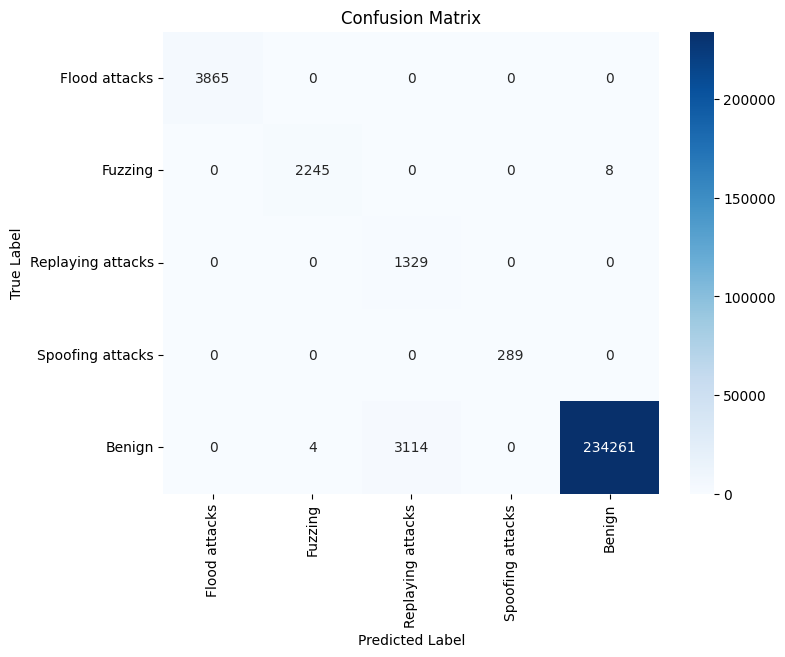

In [13]:
# Confusion Matrix as an Image
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()